In [1]:
import random
import json 

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer


import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR

# !pip install transformers
import transformers
from transformers import BertTokenizer, BertModel, BertConfig, AdamW

import matplotlib.pyplot as plt
import seaborn as sns

#from apex import amp

# ensure reproducability
#torch.seed(25)
torch.manual_seed(25)
torch.cuda.manual_seed_all(25)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(25)
random.seed(25)


In [2]:
# Initialization
opt_level = 'O1'
#apex.amp.initialize(model, optimizer, opt_level=opt_level)

torch.cuda.amp.GradScaler(
    init_scale=65536.0, growth_factor=2.0, backoff_factor=0.5,
    growth_interval=2000, enabled=True
)


In [3]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device = 'cuda'

In [4]:
print(device)

cuda


source
https://colab.research.google.com/drive/1d8N-ZLDS4FcmBDDG19gxbt_lSKglnwKq#scrollTo=mgX-jLdjw3Hl <br>
https://github.com/kaushaltrivedi/bert-toxic-comments-multilabel/blob/master/toxic-bert-multilabel-classification.ipynb

<br>
optimized with: <br>
https://pytorch.org/docs/stable/notes/amp_examples.html

<br>
Additional info <br>
https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1

In [5]:
#df = pd.read_csv("./data/train.csv")
#df['list'] = df[df.columns[2:]].values.tolist()
#new_df = df[['comment_text', 'list']].copy()
#new_df.head()

In [6]:
def extract_json_object(filename):
    with open(file, "r", encoding='utf-8') as read_file:
        json_array = json.load(read_file)
    json_data = []    
    #parse the data
    for item in json_array:
        details = {"id":None, "labels":None, "text":None}
        details['id'] = item['id']
        try: 
            details['labels'] = item['labels']
        except KeyError: 
            details['labels'] = []         
        details['text'] = item['text']
        json_data.append(details)

    
    return json_data






In [7]:
# file paths
lst_file_path=[]

lst_file_path.append("../data/training_data_task3.txt")

lst_file_path.append("../data/validation_data_task3.txt")


# List of keys 
dataset = ["training", "validation"] 
# empty dictionary
dic_datasets =  dict.fromkeys(dataset, pd.DataFrame()) 


In [8]:
for i, file in enumerate(lst_file_path):
    print('loading'+ file)
    dic_datasets[dataset[i]] = pd.DataFrame(extract_json_object(extract_json_object))

loading../data/training_data_task3.txt
loading../data/validation_data_task3.txt


In [9]:
df_training = pd.DataFrame(dic_datasets['training'][['id','labels','text']])
df_training.labels = df_training.labels.apply(lambda y: ['no_class'] if len(y)==0 else y)

df_val = pd.DataFrame(dic_datasets['validation'][['id','labels','text']])
df_val.labels = df_val.labels.apply(lambda y: ['no_class'] if len(y)==0 else y)


In [10]:
print('average sentence length: ', df_training.text.str.split().str.len().mean())
print('stdev sentence length: ', df_training.text.str.split().str.len().std())

average sentence length:  17.743046357615896
stdev sentence length:  11.849193359901824


In [11]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 20
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 18
#LEARNING_RATE = 1e-05
#LEARNING_RATE = 0.000009
LEARNING_RATE = 0.005
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

BERT input representation. The input embeddings are the sum of the token embeddings, the segmentation embeddings and the position embeddings. <br>
The first token of every sequence is always a special clas- sification token ([CLS]). <br>
The final hidden state corresponding to this token is used as the ag- gregate sequence representation for classification tasks. Sentence pairs are packed together into a single sequence. <br>
We differentiate the sentences in two ways. First, we separate them with a special token ([SEP]). Second, we add a learned embed- ding to every token indicating whether it belongs to sentence A or sentence B. <br>
A positional embedding is also added to each token to indicate its position in the sequence. <br>
We are required to: <br>
Add special tokens to the start and end of each sentence. <br>
Pad & truncate all sentences to a single constant length. <br>
Explicitly differentiate real tokens from padding tokens with the “attention mask”. <br>

[SEP] <br>
At the end of every sentence, we need to append the special [SEP] token. <br>
This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?).<br>
Here we are not certain yet why the token is still required when we have only single-sentence input, but it is! <br>
[CLS]<br>
For classification tasks, we must prepend the special [CLS] token to the beginning of every sentence.<br>

For classification tasks, we must prepend the special [CLS] token to the beginning of every sentence.
This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).
On the output of the final (12th) transformer, only the first embedding (corresponding to the [CLS] token) is used by the classifier.
“The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks.”
Also, because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector.

In [12]:
# note: a gelu hidden activation function is being usedf

In [13]:

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig(vocab_size=30522, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, 
                           intermediate_size=3072, hidden_act='gelu', 
                           hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1, 
                           max_position_embeddings=512, type_vocab_size=2, initializer_range=0.02, 
                           layer_norm_eps=1e-12, pad_token_id=0, 
                           gradient_checkpointing=False, position_embedding_type='absolute', use_cache=True)



In [14]:
df_training.text.index

RangeIndex(start=0, stop=755, step=1)

In [15]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.text
        self.targets = self.data[[
                                    'Appeal to (Strong) Emotions',
                                    'Appeal to authority',
                                    'Appeal to fear/prejudice',
                                    'Bandwagon',
                                    'Black-and-white Fallacy/Dictatorship',
                                    'Causal Oversimplification',
                                    'Doubt',
                                    'Exaggeration/Minimisation',
                                    'Flag-waving',
                                    'Glittering generalities (Virtue)',
                                    'Loaded Language',
                                    "Misrepresentation of Someone's Position (Straw Man)",
                                    'Name calling/Labeling',
                                    'Obfuscation, Intentional vagueness, Confusion',
                                    'Presenting Irrelevant Data (Red Herring)',
                                    'Reductio ad hitlerum',
                                    'Repetition',
                                    'Slogans',
                                    'Smears',
                                    'Thought-terminating cliché',
                                    'Transfer',
                                    'Whataboutism',
                                    'no_class']].to_numpy()
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        #print(index)
        #print(self.comment_text.index)
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        # inputs = self.tokenizer.encode_plus(
        #    comment_text,
        #    None,
        #    add_special_tokens=True,
        #    truncation=True,
        #    max_length=self.max_len,
        #    pad_to_max_length=True,
        #    #padding=True,
        #    #padding='longest',
        #    return_token_type_ids=True
        # )
        inputs = tokenizer.encode_plus(
                    comment_text, 
                    add_special_tokens = True,    
                    truncation = True, 
                    max_length=self.max_len,
                    padding = "max_length", 
                    return_attention_mask = True, 
                    #return_tensors = "pt"
                    return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [16]:
#new_df[1:1000]

In [17]:
mlb = MultiLabelBinarizer(sparse_output=True)

df_concat_labels = pd.concat([df_training.pop('labels'), df_val.pop('labels')])
concat_labels = df_training.join(pd.DataFrame.sparse.from_spmatrix(
                    mlb.fit_transform(df_concat_labels),
                    index=df_concat_labels.index,
                    columns=mlb.classes_))


df_training = concat_labels[0:len(df_training)]
df_training.reset_index(inplace=True)

df_val = concat_labels[len(df_training):]
df_val.reset_index(inplace=True)

In [18]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8

#new_df2 = new_df[1:200]
train_dataset=df_training
test_dataset=df_val
#train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df_concat_labels.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (895,)
TRAIN Dataset: (755, 26)
TEST Dataset: (140, 26)


In [19]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [20]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

#class BERTClass(torch.nn.Module):
# Initializing a model from the bert-base-uncased style configuration

class BertClass(transformers.PreTrainedModel):
    def __init__(self, config):
        super(BertClass, self).__init__(config)
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 23)
    
    def forward(self, ids, mask, token_type_ids):
        #print(ids)
        #print(mask)
        #_,
        #print(type(self.l1(input_ids =ids, attention_mask = mask, token_type_ids = token_type_ids)))
        #print(self.l1(input_ids =ids, attention_mask = mask, token_type_ids = token_type_ids))
        # transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions -> out of self.l1, need the tensor poooler_output
        output_1= self.l1(input_ids =ids, attention_mask = mask, token_type_ids = token_type_ids).pooler_output
        #print(output_1)
        #print(type(output_1))
        #print(_)
        #print(type(_))
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BertClass(configuration)
# Accessing the model configuration
configuration = model.config
model.to(device)





BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

why this loss function was selected:
nn.CrossEntropyLoss uses the target to index the logits in your model’s output.<br>
Thus it is suitable for multi-class classification use cases (only one valid class in the target). <br>

nn.BCEWithLogitsLoss on the other hand treats each output independently and is suitable for multi-label classification use cases.<br>

In [21]:
# contains a sigmoids activation function built in.
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)


In [22]:
#optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

replaced adam optimizatizer with Adafactor -> better designed for BERT
https://arxiv.org/pdf/1804.04235.pdf

In [23]:
# replace AdamW with Adafactor

optimizer = transformers.Adafactor(
    model.parameters(),
    lr=None,  # when using warm up and relative step, LR is auto determined
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.82, #0.8
    beta1=None, # <- used for L1 regularization
    weight_decay=0.0002, # L2 regularization, to prevent overfitting  (beta2)
    relative_step=True,
    scale_parameter=False,
    warmup_init=True
)

In [24]:
def train(epoch):
    scaler = torch.cuda.amp.GradScaler()
    model.train()

    for _,data in enumerate(training_loader):
        optimizer.zero_grad()
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device)
            #print(targets)
        with torch.cuda.amp.autocast():
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
        #print(data[_])
        #print(_)    
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loss = loss.detach().cpu().numpy()
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')
    #torch.cuda.empty_cache()
        #loss.backward()
        #optimizer.step()

In [25]:
for epoch in range(EPOCHS):
    torch.cuda.empty_cache()
    train(epoch)

Epoch: 0, Loss:  0.7665826678276062


D:\Users\sync\anaconda3\envs\pytorch\lib\site-packages\transformers\optimization.py:557: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))


Epoch: 0, Loss:  0.5861840844154358
Epoch: 1, Loss:  0.5662222504615784
Epoch: 1, Loss:  0.3663105368614197
Epoch: 2, Loss:  0.38364365696907043
Epoch: 2, Loss:  0.2682138979434967
Epoch: 3, Loss:  0.31528544425964355
Epoch: 3, Loss:  0.25678369402885437
Epoch: 4, Loss:  0.2576950788497925
Epoch: 4, Loss:  0.2572017312049866
Epoch: 5, Loss:  0.21703098714351654
Epoch: 5, Loss:  0.2526223361492157
Epoch: 6, Loss:  0.27538278698921204
Epoch: 6, Loss:  0.2530592083930969
Epoch: 7, Loss:  0.2756781280040741
Epoch: 7, Loss:  0.24745693802833557
Epoch: 8, Loss:  0.26590877771377563
Epoch: 8, Loss:  0.36833298206329346
Epoch: 9, Loss:  0.2033199667930603
Epoch: 9, Loss:  0.33593347668647766
Epoch: 10, Loss:  0.21334530413150787
Epoch: 10, Loss:  0.25065740942955017
Epoch: 11, Loss:  0.18506771326065063
Epoch: 11, Loss:  0.17327702045440674
Epoch: 12, Loss:  0.18620742857456207
Epoch: 12, Loss:  0.1995740383863449
Epoch: 13, Loss:  0.185245543718338
Epoch: 13, Loss:  0.1856890171766281
Epoch: 

In [26]:
 torch.cuda.empty_cache()

In [27]:
def validation():
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    #track variables
    true_labels,pred_labels = [],[]

    # Predict
    for _, data in enumerate(testing_loader, 0):
        #print(_)
        
        #prepare data to feed into model
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
       
        with torch.no_grad():
            
            # Forward pass
            outputs = model(ids, mask, token_type_ids)
            b_logit_pred = outputs
            pred_label = b_logit_pred

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            targets = targets.to('cpu').numpy()

        #tokenized_texts.append(b_input_ids)
        #logit_preds.append(b_logit_pred)
        true_labels.append(targets)
        pred_labels.append(pred_label)

    # Flatten outputs
    #tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
    # print(true_labels)
    # print(pred_labels)
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]
    # Converting flattened binary values to boolean values
    true_bools = [tl==1 for tl in targets]
    
    return true_labels, true_bools, pred_labels

In [28]:
col =  ['Appeal to (Strong) Emotions',
                                    'Appeal to authority',
                                    'Appeal to fear/prejudice',
                                    'Bandwagon',
                                    'Black-and-white Fallacy/Dictatorship',
                                    'Causal Oversimplification',
                                    'Doubt',
                                    'Exaggeration/Minimisation',
                                    'Flag-waving',
                                    'Glittering generalities (Virtue)',
                                    'Loaded Language',
                                    "Misrepresentation of Someone's Position (Straw Man)",
                                    'Name calling/Labeling',
                                    'Obfuscation, Intentional vagueness, Confusion',
                                    'Presenting Irrelevant Data (Red Herring)',
                                    'Reductio ad hitlerum',
                                    'Repetition',
                                    'Slogans',
                                    'Smears',
                                    'Thought-terminating cliché',
                                    'Transfer',
                                    'Whataboutism',
                                    'no_class']
col2 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,21,22]

In [29]:
#for epoch in range(EPOCHS):
targets, target_labels, outputs = validation()
#targets, outputs = validation()

outputs = [pl>0.50 for pl in outputs] #boolean output after thresholding

#print(outputs)
#print(target_labels)
#print(targets)

#outputs = np.array(outputs) >= 0.5
#targets = np.array(targets) >= 0.5
#outputs = np.argmax(outputs, axis=1)
#targets = np.argmax(targets, axis=1)

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro',zero_division=1)
f1_score_macro = metrics.f1_score(targets, outputs, average='macro', zero_division=1)
#print(f"epoch = {epoch}")
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
    
ml_cm = metrics.multilabel_confusion_matrix(targets,outputs, labels=col2)

Accuracy Score = 0.05714285714285714
F1 Score (Micro) = 0.5084745762711865
F1 Score (Macro) = 0.15128119882284857


In [30]:
type(ml_cm)
print(ml_cm)

[[[125   0]
  [ 15   0]]

 [[137   0]
  [  3   0]]

 [[125   0]
  [ 15   0]]

 [[140   0]
  [  0   0]]

 [[135   0]
  [  5   0]]

 [[134   0]
  [  6   0]]

 [[121   0]
  [ 19   0]]

 [[126   0]
  [ 14   0]]

 [[132   0]
  [  8   0]]

 [[128   0]
  [ 12   0]]

 [[  0  66]
  [  0  74]]

 [[137   0]
  [  3   0]]

 [[ 92   0]
  [ 48   0]]

 [[139   0]
  [  1   0]]

 [[140   0]
  [  0   0]]

 [[137   0]
  [  3   0]]

 [[138   0]
  [  2   0]]

 [[129   0]
  [ 11   0]]

 [[  0  49]
  [  0  91]]

 [[135   0]
  [  5   0]]

 [[125   0]
  [ 15   0]]

 [[130   0]
  [ 10   0]]

 [[130   0]
  [ 10   0]]

 [[131   0]
  [  9   0]]]


0


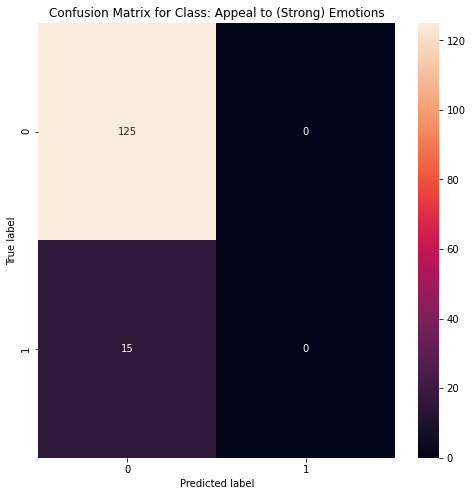

1


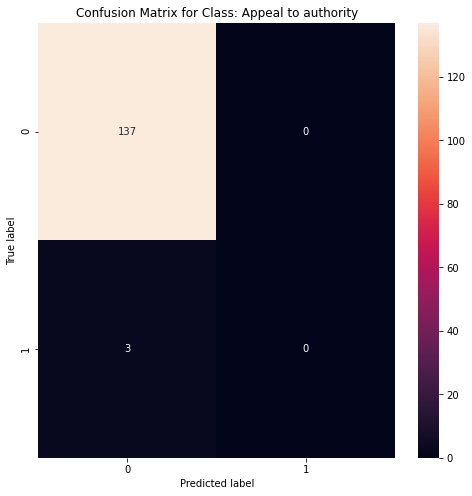

2


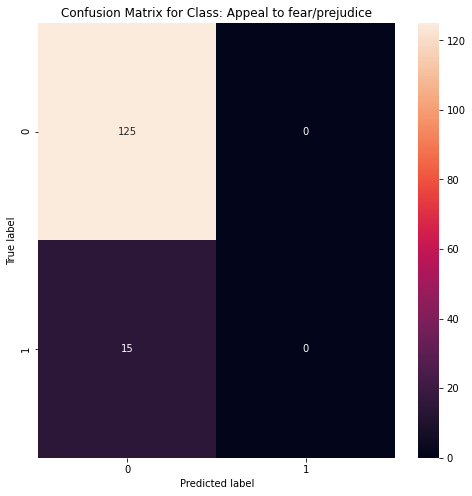

3


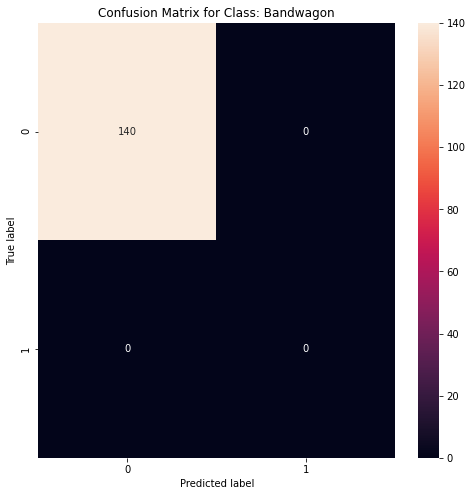

4


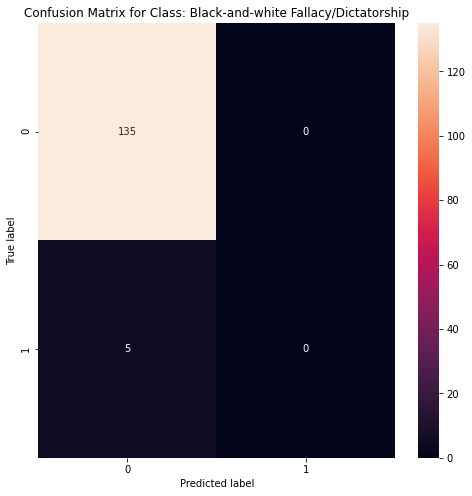

5


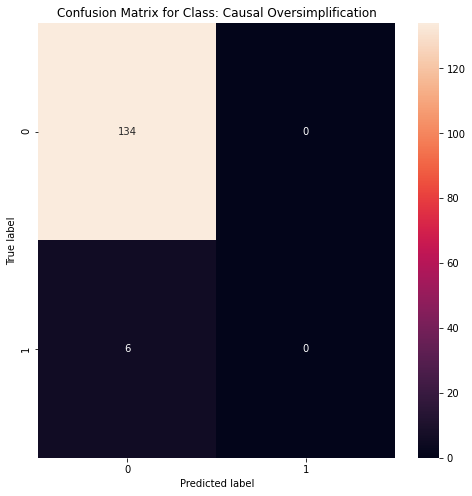

6


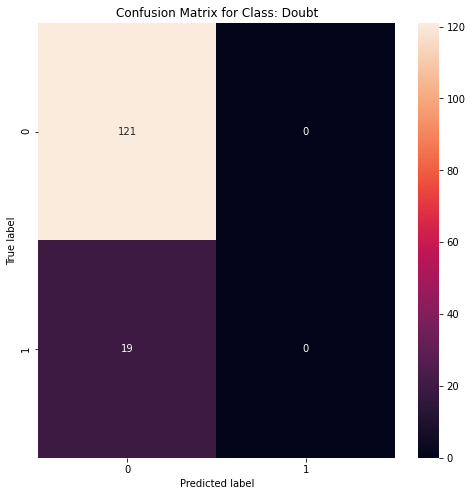

7


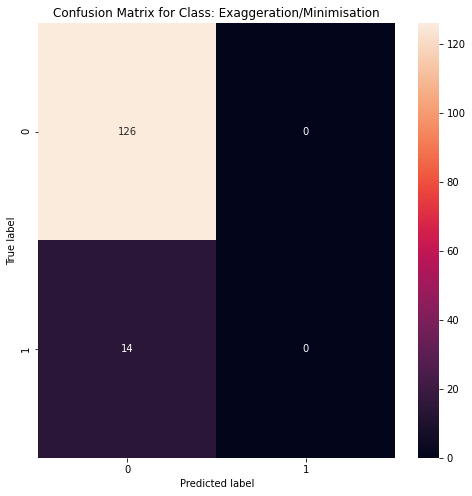

8


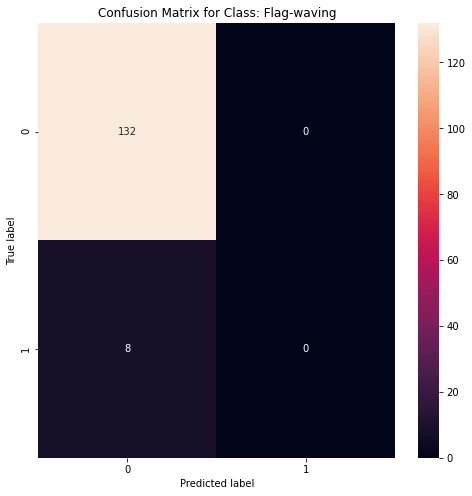

9


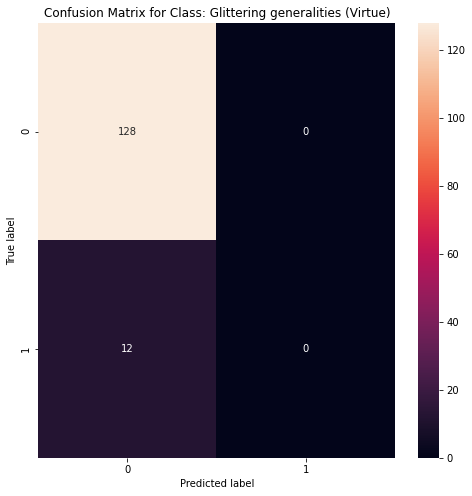

10


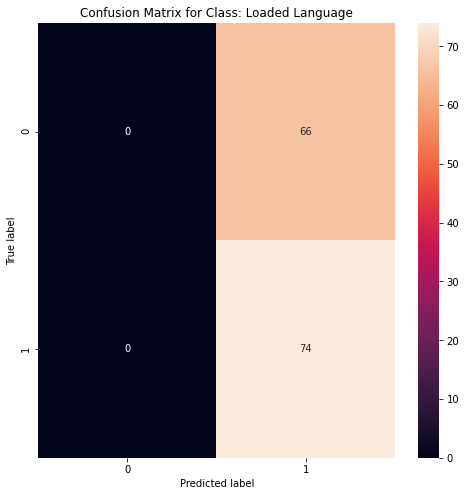

11


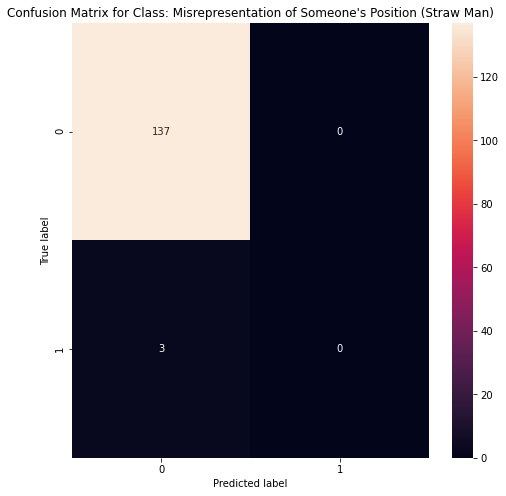

12


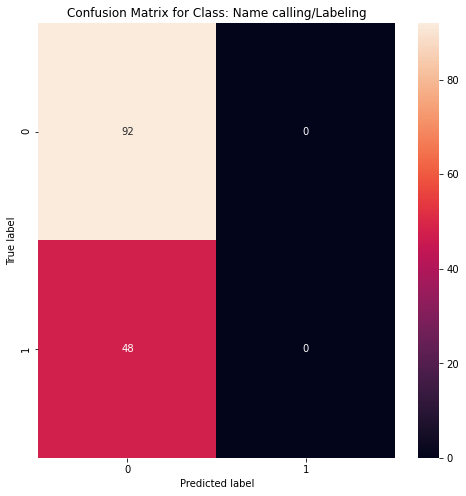

13


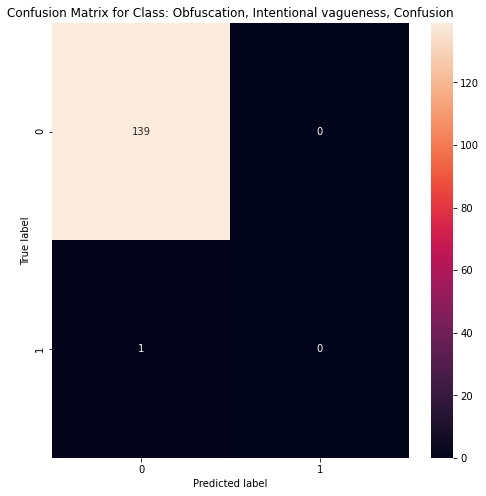

14


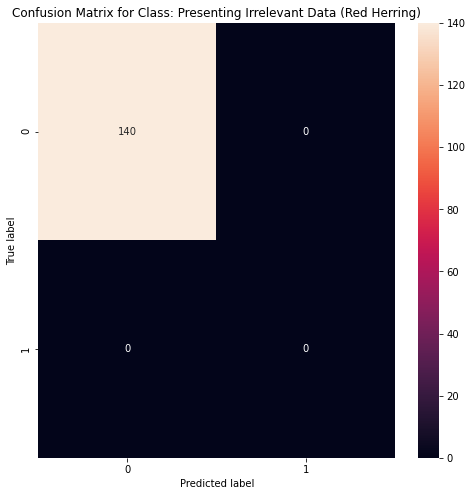

15


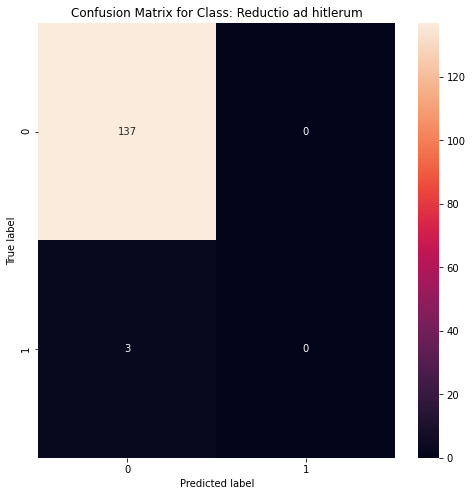

16


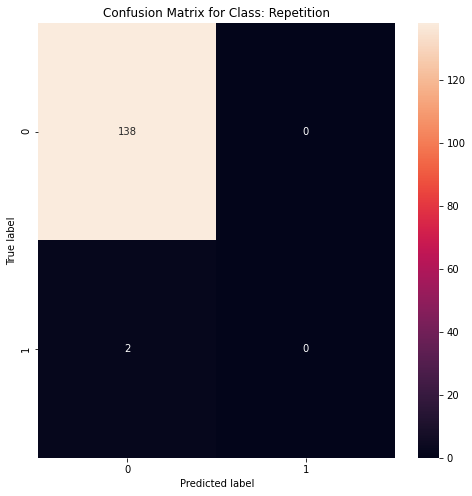

17


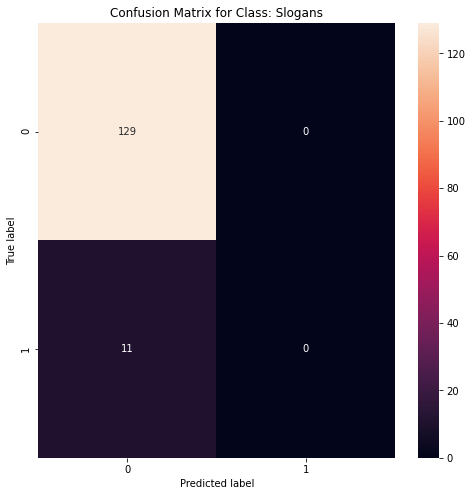

18


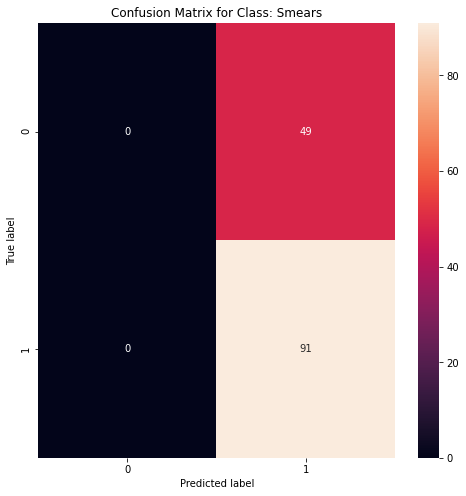

19


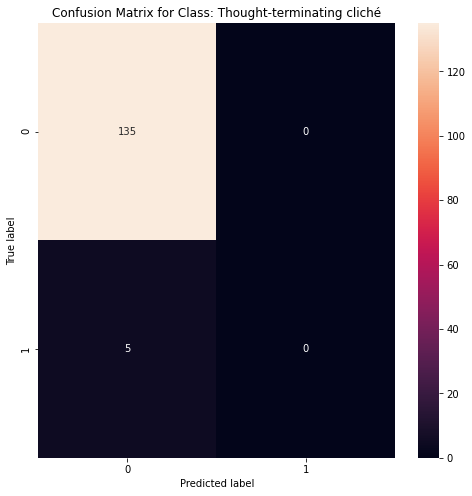

20


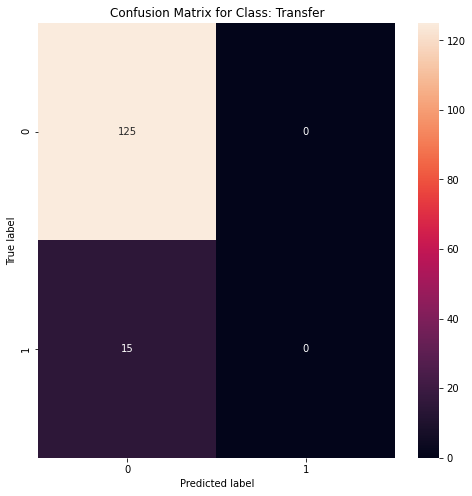

21


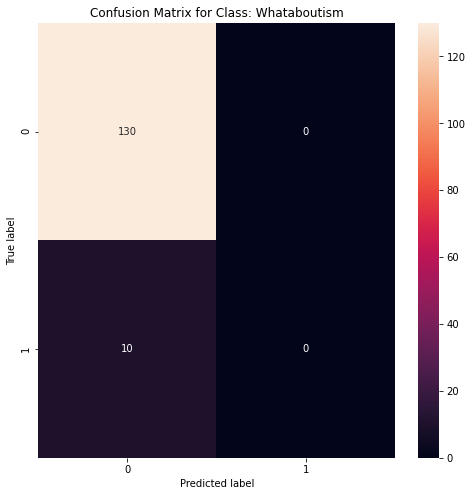

22


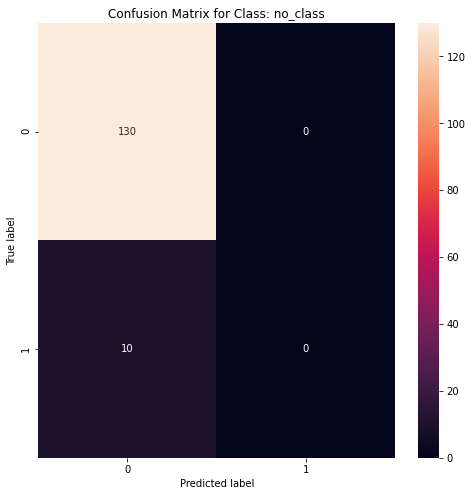

23


IndexError: list index out of range

In [31]:
for i, class_cm in enumerate(ml_cm):
    print(i)
    txt_title = "Confusion Matrix for Class: " + col[i] 
    # Transform to df for easier plotting
    plt.figure(figsize=(8,8))
    sns.heatmap(class_cm, annot=True, fmt='d')
    plt.title(txt_title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
